In [41]:
#from pydantic import BaseSettings
from functools import lru_cache
from typing import List, Mapping

import dill
from datetime import datetime, timedelta
import random

import pandas as pd
import numpy as np

import math
import seaborn as sns


from scipy.stats import multivariate_normal, multinomial
from typing import Tuple
from numpy.random import random_sample, randn
from sklearn.datasets import make_spd_matrix
from matplotlib import pyplot as plt
from sklearn.datasets import make_blobs

from collections import namedtuple
from time import process_time

# Third Party
from sklearn.compose import make_column_transformer
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import FunctionTransformer
from scipy import stats

import warnings
from collections import OrderedDict
import os

from datetime import datetime as dt

warnings.filterwarnings("ignore")

# Named tuple to help structure results
PipelinesTuple = namedtuple('PipelinesTuple', ['approved', 'rejected'])


from kuberspatiotemporal import CompoundModel, Feature, SpatialModel, KuberModel 
from kuberspatiotemporal.tools.tools import (
    check_spd, 
    check_singular,
    repr_list_ndarray
)

In [42]:

data = pd.read_csv("data/1fefac90-9903-41fe-94bb-0ed9d9abeae1.csv", usecols=["timestamp","application_uid", "auth_status","fingerprinttimezone"])

data["timestamp"] = data["timestamp"].apply(lambda x: dt.fromtimestamp(x))
df=data.copy()

data.head()

,timestamp,application_uid,auth_status,fingerprinttimezone
0,2021-03-09 00:20:44,34ddbe55360c183dcfdc6e913a23c398cc1fa77452d1b4...,expired,{value=null}
1,2021-03-09 00:20:18,34ddbe55360c183dcfdc6e913a23c398cc1fa77452d1b4...,approved,{value=null}
2,2021-03-09 00:17:49,34ddbe55360c183dcfdc6e913a23c398cc1fa77452d1b4...,approved,{value=null}
3,2021-03-09 00:17:00,34ddbe55360c183dcfdc6e913a23c398cc1fa77452d1b4...,approved,{value=null}
4,2021-03-09 00:16:30,34ddbe55360c183dcfdc6e913a23c398cc1fa77452d1b4...,approved,{value=null}


In [43]:
random.seed(10)
np.set_printoptions(suppress=True)
np.set_printoptions(precision=3)

n_component=10
data_length= 1000

np.seterr(divide='print')
train_size=0.8

gmm = SpatialModel(n_dim=1,
        min_eigval=1e-9,
        n_components=n_component,
        n_iterations=200,
        scaling_parameter=1.1,
        nonparametric=True,
        online_learning=False,
        loa=True,
        limits=np.array([[0], [24]]),
        noise_probability = 0.02)


data=df.sample(data_length)

data_approved = data[
    (data["auth_status"] == "approved")
]

data_rejected = data[
    (data["auth_status"] == "rejected")
]

msk_approved = np.random.rand(len(data_approved)) < train_size
if np.sum(~msk_approved) <= len(data_rejected):
    approved_test = pd.concat([data_approved[~msk_approved], data_rejected.sample(n=np.sum(~msk_approved))])
else:
    approved_test = pd.concat([data_approved[~msk_approved], data_rejected])
approved = {'train': data_approved[msk_approved], 'test': approved_test}





date_field: str = "timestamp"
    
pipeline_created = make_pipeline(
    make_column_transformer(
        (
            FunctionTransformer(
                lambda x: np.array(
                    [
                        pd.Timestamp(ts).hour
                        + pd.Timestamp(ts).minute / 60
                        + pd.Timestamp(ts).second / 3600
                        for ts in x
                    ]
                ).reshape(-1, 1),
            ),
            date_field,
        ),
    ),
    gmm,
)
pipeline_created.fit(approved["train"])


pipeline_created['spatialmodel'].score_threshold = pipeline_created["spatialmodel"].get_score_threshold(
    pipeline_created["columntransformer"].transform(approved['train']),
    lower_quantile=0.05,
    upper_quantile=0.95,
)

pipeline_created["spatialmodel"].loa = False

X_test= pipeline_created["columntransformer"].transform(approved["train"]).flatten()
labels= gmm.predict(X_test.reshape(-1,1))[0]


prediction = np.array([pipeline_created.score(approved["train"].iloc[[i]]) for i in range(len(approved["train"]))])
integer= [math.modf(i)[0] for i in X_test ]
floatt= [math.modf(i)[1] for i in X_test ]

NaN in responsibilities (150.000000). Please revise your random start values


In [44]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [45]:
gmm.score_samples(np.array([1,3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 
                           16, 17, 18, 19, 20, 21, 22]).reshape(-1, 1), use_bayes= True)

array([0.766, 0.421, 0.45 , 0.366, 0.203, 0.066, 0.012, 0.001, 0.   ,
       0.   , 0.   , 0.009, 0.137, 0.753, 0.899, 0.833, 0.78 , 0.744,
       0.818, 0.836, 0.787])

In [46]:
time =  np.linspace(0,24,1000)
prob =  [gmm.score_samples(np.array(t).reshape(-1,1), use_bayes=True)[0] for t in list(time)]

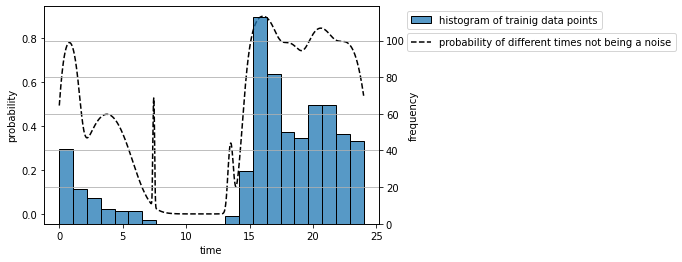

In [47]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()


sns.lineplot(time, prob, ax=ax1, color="black", linestyle='--', label = "probability of different times not being a noise")
ax1.set_xlabel("time")
plt.ylabel("probability")

sns.histplot(list(X_test), ax= ax2, label = "histogram of trainig data points")
ax1.set_ylabel("probability")
ax2.set_ylabel("frequency")

plt.grid()
ax1.legend( bbox_to_anchor=(1.07, 0.9), loc='upper left')
ax2.legend( bbox_to_anchor=(1.07, 1), loc='upper left')